# Week 6 - CNNs & Transfer Learning

Goal: Deep learning for images

- Day 36: Explore CIFAR-10 
- Day 37: Build Simlple CNN
- Day 38: Improve CNN
- Day 39: Compare Models
- Day 40: Transfer Learning
- Day 41: Visualization
- Day 42: Summary

In [2]:
import os
import random
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F # contains activations, losses, pooling, dropout, normalization...
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

SEED=42
DATA_PATH = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)



In [3]:
# Compute mean and stddev for normalization
# 1. load CIFAR-10 with just Totensor (no Normalize)
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=2)

# 2. Compute mean
n_images = 0 # counter - how many images processed so far
channel_sum = torch.zeros(3) # pixel values per channel [R, G, B]
channel_squared_sum = torch.zeros(3)

for images, _ in train_loader: # train_loader yields batches of (images, labels); images is a batch of images
    # images shape: [B, 3, 32, 32] (B=batch size; 3=color channels; 32x32=image size)
    B = images.size(0) # first dimension of images (batch size)
    n_images += B # update image counter

    # Sum over batch, height, width -> keep channel dim
    channel_sum += images.sum(dim=[0, 2, 3]) # index 0 is batch, 1 is channel, 2 and 3 are height and width
    channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])

# total number of pixels per channel
num_pixels_per_channel = n_images * 32 * 32

CIFAR10_MEAN = channel_sum / num_pixels_per_channel # mean of pixel values in the training set per color channel

# E[x^2]
mean_of_squares = channel_squared_sum / num_pixels_per_channel

# Var(X) = E[X^2] - (E[X])^2
var = mean_of_squares - CIFAR10_MEAN**2 # my often used formula: 
CIFAR10_STD = torch.sqrt(var)


print(f"Mean: {CIFAR10_MEAN}")
print(f"Std: {CIFAR10_STD}")


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


## Day 36 - Explore DIFAR-10 dataset
1. Load dataset
2. Visualize samples
3. Prep dataloaders

In [4]:
def get_cifar10_datasets(use_augmentation: bool=False):
    # return train/val/test datasets with or without augmentation
    if use_augmentation:
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(), 
            transforms.RandomCrop(32, padding=4), 
            transforms.ToTensor(), #scale pixel values to float 0 to 1
            transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ])

    full_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)


    # Create a validation split from train
    val_size = 5000
    train_size = len(full_train) - val_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])
    return train_dataset, val_dataset, test_dataset, full_train.classes

#A DataLoader: Takes a Dataset and: - groups samples into mini-batches; 
#optionally shuffles the order (for training); can load data in parallel (num_workers)
def get_dataloaders(batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, use_augmentation: bool = False):
    # num_workers: how many subprocesses to use for data loading, more is faster
    # batch_size: how many samples per batch to load
    train_ds, val_ds, test_ds, classes = get_cifar10_datasets(use_augmentation)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True) # pin_memory moving data from CPU to GPU
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader, classes


def denormalize(img_tensor):
    """ Denormalize a signle image tensor (C, H, W) for visualization. """
    mean = torch.tensor(CIFAR10_MEAN).view(3, 1, 1) # reshaping the tensor to (channels, 1, 1) (1 for height and width)
    std = torch.tensor(CIFAR10_STD).view(3, 1, 1)
    return img_tensor * std + mean

def show_sample_batch(loader, classes, n=25):
    """ Visualize a small batch of images. """
    images, labels = next(iter(loader))
    images = images[:n]
    labels = labels[:n]

    grid_size = int(np.sqrt(n))
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(grid_size, grid_size, i+1) # rows, cols, index
        img = denormalize(images[i]).permute(1, 2, 0).numpy() # CHW(PyTorch) to HWC (Matplotlib) for plt
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show() 



    

Loading data and exploring...
Train batches: 352 |Val batches: 40 |Test batches: 79


/Users/CQ/miniconda3/envs/ml_foundations/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_1668/2096958227.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(CIFAR10_MEAN).view(3, 1, 1) # reshaping the tensor to (channels, 1, 1) (1 for height and width)
/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_1668/2096958227.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(CIFAR10_STD).view(3, 1, 1)


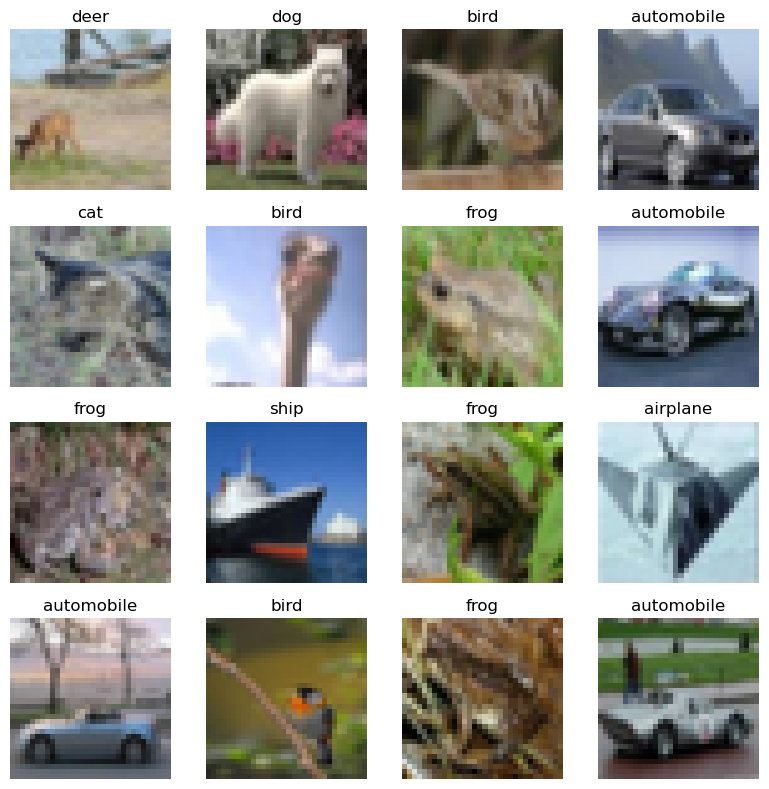

In [5]:
if __name__ == "__main__":
    print("Loading data and exploring...")
    train_loader_base, val_loader_base, test_loader_base, classes = get_dataloaders(
        batch_size = BATCH_SIZE,
        use_augmentation=False
    )

    print(f"Train batches: {len(train_loader_base)} |"
          f"Val batches: {len(val_loader_base)} |"
          f"Test batches: {len(test_loader_base)}")
    show_sample_batch(train_loader_base, classes, n=16)

## Day 37 - Build Simple CNN
1. Conv -> Pool -> Dense architecture
2. Train

In [6]:
class SimpleCIFARCNN(nn.Module):
    def __init__(self, num_classes: int = 10): # for CIFAR-10, one image is (3, 32, 32) = (channels, height, width)
        super().__init__()
        self.features = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #(3=input channel, 32 output channels)  3x32x32 -> 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(2), # 32x32x32 -> 32x16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32x16x16 -> 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x16x16 -> 64x8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # flattens (c, H, W) into one vector per image (64 * 8 * 8 = 4096)
            nn.Linear(64 * 8 * 8, 128), #input 4096, output 128
            nn.ReLU(), # no change
            nn.Linear(128, num_classes) # input 128, output 10
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Structure
- Features: Conv2d -> ReLU -> MaxPool2d -> Conv2d -> ReLU -> MaxPool2d
- Classifier: Flatten -> Linear -> ReLU -> Linear

Shapes:
- Input: (3, 32, 32)
- After features: (64, 8, 8)
- After classifier: (10)

## Day 38 - Improve CNN
1. Add dropout
2. Batch norm
3. Augmentation
4. Retrain

In [7]:
class ImprovedCIFARCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential( #3, 32, 32
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 64, 32, 32
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(2), # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128, 16, 16
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.MaxPool2d(2), # 128 x 8 x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # 128 * 8 * 8 = 8192
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # dropout with p=0.5
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# Shared training, evaluation, and utility functions

def accuracy_from_logits(logits, targets):
    ''' Compute accuracy given model logits and true targets. '''
    preds = logits.argmax(dim=1) # get predicted class indices
    corrent = (preds == targets).sum().item()
    total = targets.size(0)
    return corrent / total

def train_one_epoch(model: nn.Module, 
                    loader: DataLoader, 
                    optimizer: torch.optim.Optimizer, 
                    criterion: nn.Module,
                    device=DEVICE) -> Tuple[float, float]:
    model.train()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for xb, yb in loader: # xb: input images batch; yb: target labels batch
        xb, yb = xb.to(device), yb.to(device) #moves the batch of images to device(cpu/gpu) bcz GPU training is faster

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == yb).sum().item() 
            #logits.argmax(dim=1): find the index of the maximum value across the class scores.
        total_count += batch_size
    return total_loss / total_count, total_correct / total_count




In [9]:
@torch.no_grad()
def evaluate(model: nn.Module,
             loader: DataLoader, 
             criterion: nn.Module, 
             device=DEVICE) -> Tuple[float, float]:
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total_count += batch_size
    return total_loss / total_count, total_correct / total_count
                                           

In [10]:
def train_model(model, 
                train_loader, 
                val_loader, 
                num_epochs: int = 10,
                lr: float = 1e-3, 
                weight_decay: float = 0.0, 
                device = DEVICE):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": []}
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    return model, history



In [11]:
def plot_history(history: Dict[str, List[float]], label_prefix: str = "", show: bool=True):
    """ Plot training and validation loss and accuracy curves. """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label=f"{label_prefix} Train Loss")
    plt.plot(epochs, history["val_loss"], label=f"{label_prefix} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()        
    plt.title(f"{label_prefix} Loss Curve")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label=f"{label_prefix} Train Acc")
    plt.plot(epochs, history["val_acc"], label=f"{label_prefix} Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.title(f"{label_prefix} Accuracy Curve") 

    plt.tight_layout()
    if show:
        plt.show()
    

Training baseline CNN model...
Epoch 1/10 | Train Loss: 1.3744, Train Acc: 51.05% | Val Loss: 1.1192, Val Acc: 59.60%
Epoch 2/10 | Train Loss: 1.0019, Train Acc: 64.62% | Val Loss: 0.9533, Val Acc: 66.48%
Epoch 3/10 | Train Loss: 0.8477, Train Acc: 70.32% | Val Loss: 0.8782, Val Acc: 68.84%
Epoch 4/10 | Train Loss: 0.7359, Train Acc: 74.29% | Val Loss: 0.8385, Val Acc: 70.86%
Epoch 5/10 | Train Loss: 0.6378, Train Acc: 77.71% | Val Loss: 0.8061, Val Acc: 72.26%
Epoch 6/10 | Train Loss: 0.5449, Train Acc: 80.81% | Val Loss: 0.8571, Val Acc: 71.54%
Epoch 7/10 | Train Loss: 0.4612, Train Acc: 84.00% | Val Loss: 0.8838, Val Acc: 72.26%
Epoch 8/10 | Train Loss: 0.3844, Train Acc: 86.48% | Val Loss: 0.9112, Val Acc: 71.70%
Epoch 9/10 | Train Loss: 0.2980, Train Acc: 89.77% | Val Loss: 0.9830, Val Acc: 71.26%
Epoch 10/10 | Train Loss: 0.2327, Train Acc: 92.16% | Val Loss: 1.0822, Val Acc: 71.24%


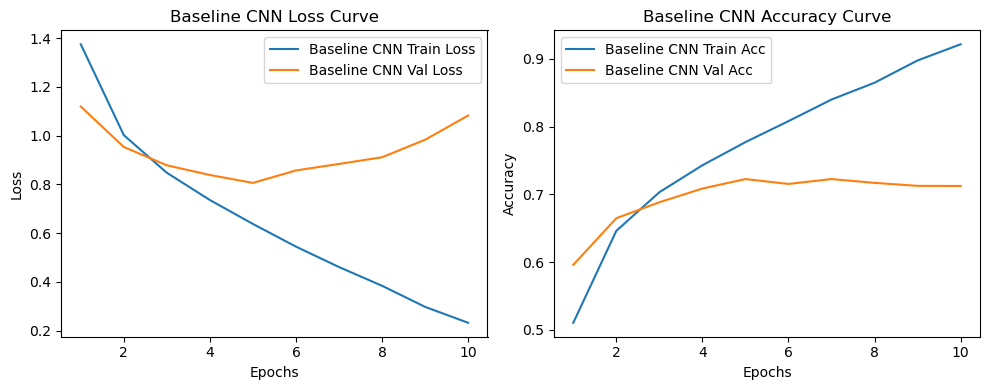

In [12]:
# Baseline CNN model training and evaluation
print("Training baseline CNN model...")
baseline_model = SimpleCIFARCNN(num_classes=10)
baseline_model, baseline_history = train_model(
    baseline_model, 
    train_loader_base, 
    val_loader_base, 
    num_epochs=10, 
    lr=1e-3
)
plot_history(baseline_history, label_prefix="Baseline CNN")




What the loss curves say (left plot)
- Training loss (blue) steadily decreases from ~1.38 → ~0.23 across epochs. The model is fitting the training set better and better.
- Validation loss (orange) decreases at first, reaching its best point around epoch ~4–5 (roughly ~0.80), then starts increasing to ~1.08 by epoch 10.
- Interpretation: after ~epoch 4–5, the model’s updates keep improving training performance but harm generalization—it’s learning training-specific quirks/noise.

What the accuracy curves say (right plot)
- Training accuracy increases continuously from ~0.51 → ~0.92.
- Validation accuracy improves early (~0.60 → ~0.72 by ~epoch 4–5) and then plateaus / slightly drifts down (~0.71 by epoch 10).
- Interpretation: additional training past ~epoch 4–5 mostly boosts training accuracy, not validation accuracy. The widening gap between train and val accuracy is the generalization gap.

Bottom line
- Your “best” checkpoint for real-world performance is likely around epoch 4–5 (minimum validation loss / peak validation accuracy).
- Training longer is not helping validation performance; it’s overfitting.

Practical next steps
1. Early stopping: stop training when validation loss stops improving (patience 1–3 epochs), and save the best-val checkpoint.
2. Regularization: add/raise dropout, add weight decay (L2) (e.g., 1e-4 to 5e-4), consider label smoothing.
3. Data augmentation: random crop/flip, color jitter; for CIFAR-10 often Cutout/MixUp/CutMix help.
4. Capacity / training tweaks: slightly smaller model, or add BatchNorm (often improves generalization), and use a learning-rate scheduler.


Training improved CNN model with data augmentation...
Training Improved CNN model...
Epoch 1/15 | Train Loss: 1.8969, Train Acc: 29.62% | Val Loss: 1.6001, Val Acc: 42.22%
Epoch 2/15 | Train Loss: 1.6252, Train Acc: 38.34% | Val Loss: 1.4072, Val Acc: 48.34%
Epoch 3/15 | Train Loss: 1.5223, Train Acc: 42.70% | Val Loss: 1.2853, Val Acc: 53.18%
Epoch 4/15 | Train Loss: 1.4655, Train Acc: 45.36% | Val Loss: 1.2534, Val Acc: 54.18%
Epoch 5/15 | Train Loss: 1.4230, Train Acc: 47.20% | Val Loss: 1.2351, Val Acc: 56.52%
Epoch 6/15 | Train Loss: 1.3925, Train Acc: 48.22% | Val Loss: 1.1894, Val Acc: 58.18%
Epoch 7/15 | Train Loss: 1.3731, Train Acc: 49.37% | Val Loss: 1.1543, Val Acc: 60.68%
Epoch 8/15 | Train Loss: 1.3505, Train Acc: 50.45% | Val Loss: 1.1376, Val Acc: 59.86%
Epoch 9/15 | Train Loss: 1.3308, Train Acc: 50.71% | Val Loss: 1.1198, Val Acc: 60.74%
Epoch 10/15 | Train Loss: 1.3087, Train Acc: 51.85% | Val Loss: 1.1083, Val Acc: 61.10%
Epoch 11/15 | Train Loss: 1.2922, Train Acc:

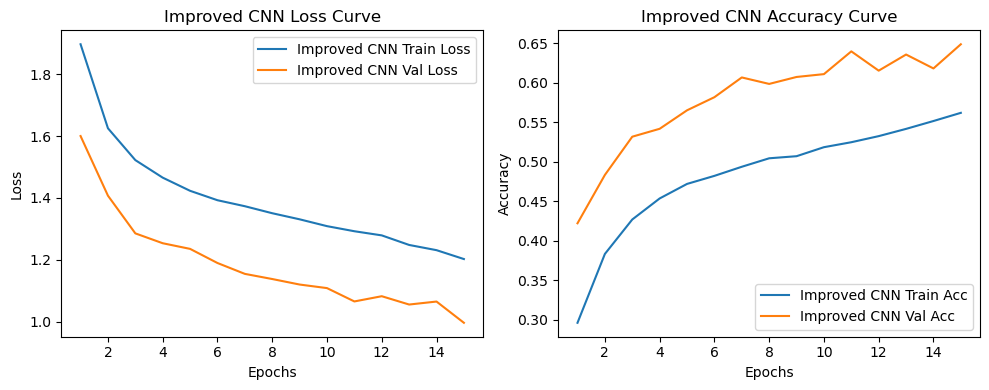

In [13]:
# Improved CNN model training and evaluation with data augmentation
print("Training improved CNN model with data augmentation...")
train_loader_aug, val_loader_aug, test_loader_aug, classes = get_dataloaders(
    batch_size = BATCH_SIZE,
    use_augmentation=True
)
print("Training Improved CNN model...")
Improved_model = ImprovedCIFARCNN(num_classes=10)
Improved_model, Improved_history = train_model(
    Improved_model, 
    train_loader_aug,   
    val_loader_aug,
    num_epochs=15,
    lr=1e-3,
    weight_decay=5e-4
)
plot_history(Improved_history, label_prefix="Improved CNN")



Loss curves (left)
- Train loss decreases (≈1.9 → ≈1.2), but it stays relatively high.
- Validation loss decreases steadily (≈1.6 → ≈1.0) and is consistently lower than training loss.
- Interpretation: the model is learning, and generalization is improving throughout the run (validation loss keeps trending down). There is no “U-shape” in validation loss, so no clear overfitting within 15 epochs.

Accuracy curves (right)
- Train accuracy rises (≈0.30 → ≈0.56).
- Validation accuracy rises (≈0.42 → ≈0.65) and is consistently higher than training accuracy.
- Interpretation: it’s unusual (but not impossible) for validation accuracy to be consistently higher than training accuracy. Common causes:
    - Strong training-time regularization (dropout, heavy augmentation, stochastic depth, etc.) makes training examples “harder” than validation.
    - Train accuracy computed in model.train() (dropout on, BatchNorm using batch stats) while val accuracy is in model.eval() (dropout off), which can inflate validation relative to training.
    - Training set is harder/noisier (more label noise) than validation, or the validation split is not representative (small/easier subset).

Bottom line diagnosis
- You have likely reduced overfitting successfully compared to the baseline.
- However, overall accuracy is still modest (val ≈0.65), and the model appears capacity-limited or overly regularized (i.e., some underfitting).
- Since validation loss is still improving at epoch 15, you also may simply need more epochs and/or a learning-rate schedule.

What to do next (high-value checks + actions)
1. Sanity check metrics (very important): Compute train accuracy in evaluation mode on the training set without augmentation, e.g. run an “eval pass” over train loader (or a separate train-eval loader). This gives an apples-to-apples train vs val comparison.
2. If you used heavy augmentation: consider dialing it back slightly (or switch to a milder policy) and see if train acc rises without hurting val.
3. If dropout/weight decay are high: reduce them a bit (e.g., lower dropout p or weight decay) to address underfitting.
4. Train longer with LR scheduling: try cosine decay or StepLR; often you’ll see val accuracy continue climbing once LR decreases.
5. If you changed architecture: consider adding a bit more capacity (more channels or another conv block) if regularization is already reasonable.


## Day 39 - Compare Models
1. Plot accuracies
2. Confusion matrix
3. Discuss

In [28]:
@torch.no_grad()
def get_all_preds_labels(model: nn.Module, loader: DataLoader, device=DEVICE) -> Tuple[torch.Tensor, torch.Tensor]:
    """ Get all predictions and true labels from the dataloader. """
    model.eval()
    all_preds = []
    all_labels = []

    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
         #“Get the predicted class for each sample, ensure it’s on the CPU, and convert it to a NumPy array.”
        labels = yb.cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

    

In [29]:
def plot_confusion(model, loader, classes, normalize: bool = True):
    """ Plot confusion matrix for the model on the given dataloader."""
    y_pred, y_true = get_all_preds_labels(model, loader)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))





Plotting confusion matrix for improved model


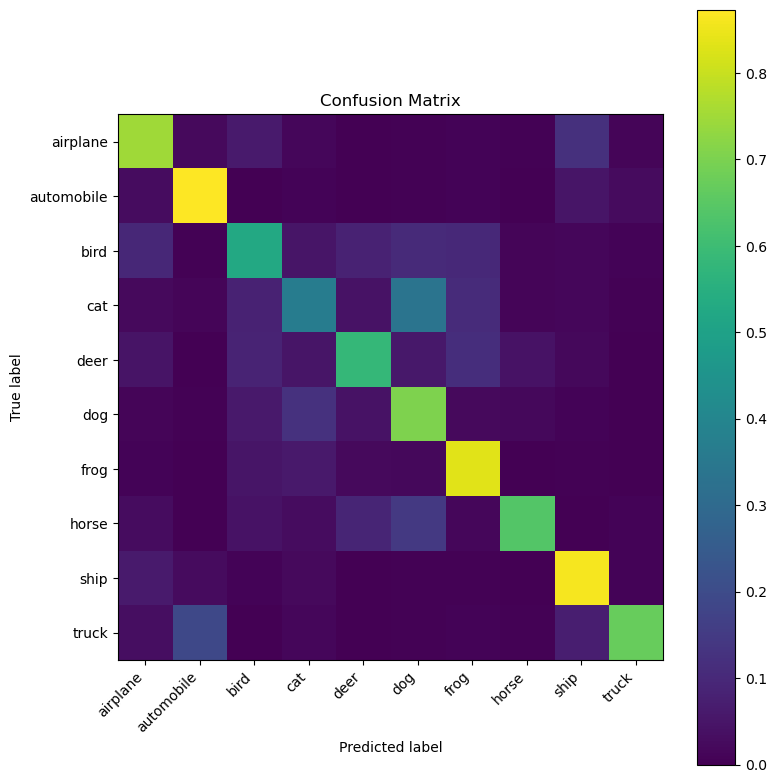

Classification Report:
              precision    recall  f1-score   support

    airplane       0.69      0.75      0.72      1000
  automobile       0.77      0.87      0.82      1000
        bird       0.57      0.53      0.55      1000
         cat       0.50      0.37      0.42      1000
        deer       0.67      0.58      0.62      1000
         dog       0.51      0.70      0.59      1000
        frog       0.68      0.83      0.75      1000
       horse       0.87      0.64      0.74      1000
        ship       0.73      0.86      0.79      1000
       truck       0.90      0.67      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [30]:
print("Plotting confusion matrix for improved model")

plot_confusion(Improved_model, test_loader_aug, classes)


- Stronger classes: automobile, ship, frog, truck
- Weaker classes: cat, bird, dog
- eg. Low cat recall means many true cats are being predicted as other classes - likely dog or similar animals. 

From the matrix graph
- Rows are true labels
- Columns - predicted labels
- A cell(i, j) tells you: "Among images that are truly class i, what fraction were predicted as class j?"

Strong diagonal: automobile, ship, frog

Most confused: cat <-> dog
- Cat recall = 0.37 (most cats are missed)
- Dog precision = 0.51 (many "dog" predictions are actually cats or other animals)

Vehicle confusion: truck -> automobile
- Many trucks are classified as cars
- Truck precision is very high (0.90) but recall is only 0.67. 
    - It means: when the model says "truck", it's usually right, 
    - but it often fails to call trucks trucks (it calls them automobiles instead)

Animal confusions: deer <-> horse
- Deer's recall is 0.58, hourse's recall is 0.64
- These classes share similar silhouettes/backgrounds at low resolution


How to use this to improve the model
- To reduce cat <-> dog errors: increase capacity (or move to ResNet18 transfer), use stronger augmentation (but not so strong you underfit), and consider MixUp/CutMix + label smoothing. 
- To reduce trck -> automobile: augment with random crops that preserve the object, and consider training longer with an LR schedule so the model learns finer-grained features.  

## Day 40 - Transfer Learning with ResNet18
1. Fine-tune ResNet18
2. Evaluate

In [ ]:
def build_resnet18_transfer(num_classes: int=10, freeze_backbone: bool = True): #(note)
    """ Build a ResNet18 model for transfer learning on CIFAR-10. """
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

Note:
- If freeze_backbone=True, then during training:
    - Only the final layer (model.fc) learns
    - Everything else stays fixed (acts like a feature extractor)
- If freeze_backbone=False, then:
    - The whole network learns (fine-tuning)
    - Usually you use a smaller learning rate and often better augmentation



Building and training ResNet18 transfer learning model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/qinyanwang/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 81.5MB/s]
/Users/CQ/miniconda3/envs/ml_foundations/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 | Train Loss: 1.0684, Train Acc: 62.98% | Val Loss: 0.9275, Val Acc: 68.64%
Epoch 2/10 | Train Loss: 0.7644, Train Acc: 74.21% | Val Loss: 0.8070, Val Acc: 72.96%
Epoch 3/10 | Train Loss: 0.6696, Train Acc: 77.10% | Val Loss: 0.6944, Val Acc: 76.30%
Epoch 4/10 | Train Loss: 0.6192, Train Acc: 78.99% | Val Loss: 0.6853, Val Acc: 76.36%
Epoch 5/10 | Train Loss: 0.5772, Train Acc: 80.32% | Val Loss: 0.6092, Val Acc: 78.90%
Epoch 6/10 | Train Loss: 0.5539, Train Acc: 80.78% | Val Loss: 0.6083, Val Acc: 78.34%
Epoch 7/10 | Train Loss: 0.5229, Train Acc: 82.07% | Val Loss: 0.5862, Val Acc: 80.26%
Epoch 8/10 | Train Loss: 0.5025, Train Acc: 82.88% | Val Loss: 0.6179, Val Acc: 79.50%
Epoch 9/10 | Train Loss: 0.4935, Train Acc: 83.00% | Val Loss: 0.5706, Val Acc: 80.60%
Epoch 10/10 | Train Loss: 0.4703, Train Acc: 83.92% | Val Loss: 0.5563, Val Acc: 81.00%


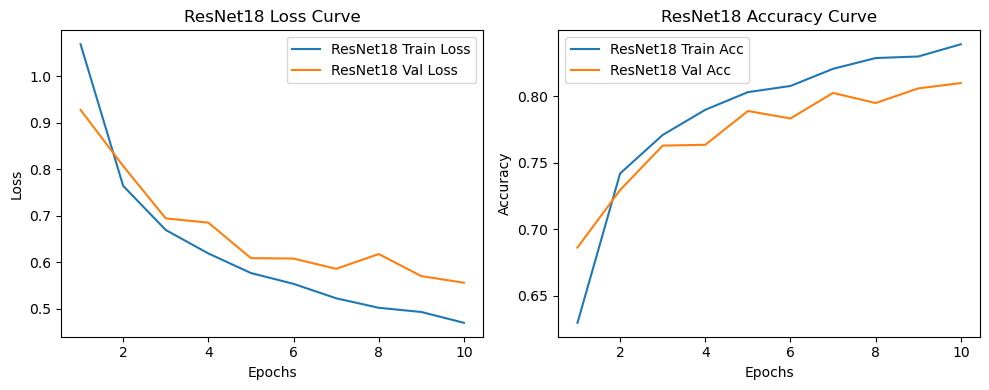

In [31]:
print("\nBuilding and training ResNet18 transfer learning model...")

resnet_model = build_resnet18_transfer(num_classes=10, freeze_backbone=False)
resnet_model, resnet_history = train_model(
    resnet_model, 
    train_loader_aug,   
    val_loader_aug,
    num_epochs=10,
    lr=1e-3,
    weight_decay=1e-4
)
plot_history(resnet_history, label_prefix="ResNet18")



Loss curves (left)
- Training loss (blue) drops steadily (roughly ~1.06 → ~0.47). That means the model is consistently fitting the training data better each epoch.
- Validation loss (orange) also drops overall (roughly ~0.93 → ~0.55), which means generalization is improving, not just memorization.
- The gap between train and val loss grows a bit as epochs increase (val loss stays higher). That’s normal, but it also indicates mild overfitting starting to appear (the model keeps improving on train faster than on val).
- The small bump around ~epoch 8 in validation loss suggests a bit of instability/noise (common with mini-batch training), or the model briefly started to overfit that epoch.
- Interpretation: Training is healthy; validation is improving; mild overfitting but not severe.

Accuracy curves (right)
- Training accuracy (blue) rises steadily (about ~0.63 → ~0.83+).
- Validation accuracy (orange) rises too (about ~0.69 → ~0.81), tracking training pretty closely.
- The generalization gap (train acc minus val acc) at the end looks small (a few percentage points). That’s generally a good sign.
- Minor dips/plateaus (e.g., around epochs 6–8) are typical and usually reflect variance in validation batches or learning rate dynamics.
- Interpretation: The model is learning features that transfer to unseen data; overfitting is limited.

What to conclude / what to do next
- You’re likely near a good stopping point: validation metrics are improving but slowly after ~epoch 6–7.
- If your goal is best validation performance, consider:
    - Early stopping on lowest validation loss (or highest val accuracy).
    - Learning rate scheduling (e.g., ReduceLROnPlateau or cosine decay) to squeeze more gains after the early rapid improvement.
    - If overfitting increases with more epochs: stronger data augmentation, weight decay (L2), or dropout.


## Day 41 - Visualization
1. Visualize feature maps & saliency
2. Interpret

In [34]:
def visualize_feature_maps(model, loader, device=DEVICE, num_maps: int=6): #num_maps - how many channels (feature maps) to display
    """ Visualize some feature maps from the first convolutional layer of the model.
        Assumes model.features[0] is a Conv2d or similar."""
    
    model.eval()
    model.to(device) 

    # Grab one batch
    xb, yb = next(iter(loader))
    xb = xb.to(device) # Moves the image batch to the same device as the model

    # Register hook on first conv
    activation = {}

    def hook_fn(m, inp, out): #(see note) 
        activation["feat"] = out.detach().cpu() # stores the layer output into a dict for access later
            # detach() ensures no gradient graph is kept (memory-friendly)
            # cup() moves it to CPU so you can convert to numpy and plot
    first_conv = None # find the first conv2d layer inside model.features

    # Try to find first conv in model.features - Place holder for the layer we want to hook
    if hasattr(model, "features"): # Checks that the model has an attribute called features
        for m in model.features: # Iterates through each module (layer) in model.features
            if isinstance(m, nn.Conv2d): # Finds the first module that is a Conv2d, saves it, and stops searching
                first_conv = m
                break
    if first_conv is None:
        print("Could not find a first conv layer to visualize.")
        return # If no convolution layer is found, prints a message and exits the function
    
    # Register the hook, run one forward pass, then remove the hook
    handle = first_conv.register_forward_hook(hook_fn) # Registers the hook function to be called during forward pass
        # Attaches hook_fn to first_conv
        # This means: every time first_conv runs in a forward pass, hook_fn will be called and can capture its output
        # handle is a reference you need later to remove the hook
    _ = model(xb) # Forward pass through the model to trigger the hook and capture feature maps
        # _ is a throwaway variable since we don't need the model output here, we only care the intermediate activation
        #During this forward pass, the hook fires at first_conv and fills activation["feat"]
    handle.remove() # Remove the hook to avoid side effects in future forward passes

    # Extract feature maps for the first image in the batch
    feat_maps = activation["feat"][0] # Shape: (num_channels, H, W)
    num_maps = min(num_maps, feat_maps.size(0)) # Ensure we don't exceed available channels

    # Plot feature maps
    plt.figure(figsize=(12,4))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        fm = feat_maps[i].numpy()
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8) # Normalize to [0, 1] for visualization
        plt.imshow(fm, cmap="viridis")
        plt.axis("off")
        plt.title(f"Map {i}")
    plt.suptitle("Feature Maps from First Conv Layer")
    plt.tight_layout()
    plt.show()   
    
    


Note - hook function
- A hook is like putting a “listener” on a specific layer so you can see what goes through that layer while the model runs—without changing the model’s code.
- A hook function (in PyTorch) is a callback you register on a nn.Module (a layer) so that PyTorch automatically calls your function during the model’s execution. 
- In your code, you use a forward hook to “tap into” the first convolution layer and capture its output feature maps.
- m: the module (layer) being hooked (here, the first conv layer) 
- inp: the inputs to theat layer (usually a tuple, eg. (tensor, ))
- out: the output tensor produced by that layer (for Conv2d, typically shape[B, C, H, W])



Visualizing feature maps and saliency for improved model...


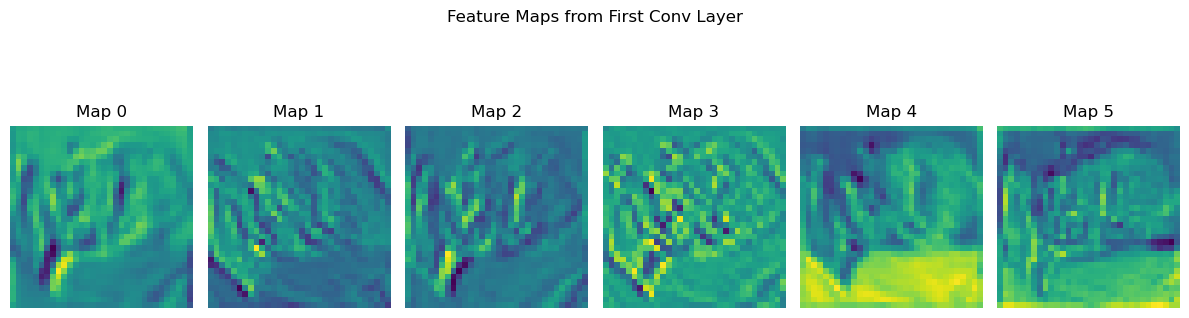

In [35]:
print("\nVisualizing feature maps and saliency for improved model...")
visualize_feature_maps(Improved_model, test_loader_aug)

What each “Map k” is
- The first conv layer has multiple filters/kernels (often 32, 64, etc.).
- Each filter produces one output channel: a 2D grid of numbers (height × width).
- “Map 0 … Map 5” are six of those output channels, visualized as images.
- So, each map answers: “Where in the image does this particular filter ‘fire’?”

What the colors mean
- Brighter/yellower regions = higher activation (the filter detected its preferred pattern strongly there).
- Darker/bluer regions = lower activation (the filter did not respond much there).
- Important: many plotting functions rescale each map independently to display it nicely. If so, you should interpret each map within itself (where it is bright vs dark), not compare brightness across different maps as absolute magnitude.

What the first conv layer typically learns
- Early layers usually detect low-level visual primitives, such as:
    - edges (vertical, horizontal, diagonal),
    - corners,
    - simple textures,
    - color contrasts / intensity gradients.
- That is exactly what your maps look like: they emphasize outlines and texture-like patterns rather than “cat” or “truck” parts.

How to interpret patterns  here
- Several maps highlight similar curved/edge structures around the central object. That usually means multiple filters are responding to related edge orientations or textures.
- Some maps light up strongly in the bottom region (e.g., Map 4/5). That often indicates a filter sensitive to a broad intensity/color region (background, shading, horizon-like boundary) rather than fine edges.
- None of the maps are “all dark,” which is good—an all-dark map can indicate a dead filter (not contributing) or a ReLU shutting everything off for that input.


## Day 42 - Summary
1. Clean
2. Documentation
3. Push notebooks

In [36]:
def summarize_results(name: str,
                      history: Dict[str, List[float]],
                      test_acc: float):
    print(f"=== {name} ===")
    best_val_acc = max(history["val_acc"])
    print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%\n")
    print()


torch.no_grad() # decorator to disable gradient calculation within the function scope
def evaluate_on_test(model, test_loader, device=DEVICE):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    return test_loss, test_acc

In [37]:
# Baseline CNN Model results
baseline_test_loss, baseline_test_acc = evaluate_on_test(baseline_model, test_loader_base)
summarize_results("Baseline CNN Model", baseline_history, baseline_test_acc)

# Improved CNN Model results
improved_test_loss, improved_test_acc = evaluate_on_test(Improved_model, test_loader_aug)
summarize_results("Improved CNN Model", Improved_history, improved_test_acc)

# ResNet18 Transfer Learning Model results
resnet_test_loss, resnet_test_acc = evaluate_on_test(resnet_model, test_loader_aug)
summarize_results("ResNet18 Transfer Learning Model", resnet_history, resnet_test_acc)

=== Baseline CNN Model ===
Best Validation Accuracy: 72.26%
Test Accuracy: 70.66%


=== Improved CNN Model ===
Best Validation Accuracy: 64.88%
Test Accuracy: 68.02%


=== ResNet18 Transfer Learning Model ===
Best Validation Accuracy: 81.00%
Test Accuracy: 81.60%


